#### 1) Write a function (ideally in Python – but you can also use any other language) that generates an undirected growing network based on the K Nearest-Neighbors (KNN) rule, as follows:

#### –Start with a clique of n0 nodes that are randomly located in the Cartesian square S=[0,1]×[0,1].

#### –Grow the network by adding one node in each iteration.  The new node must be located at a randomly chosen location within S,  and it should be connected to its K nearest neighbors.

#### Use G=KNN model (n0, K, N) as the interface of your function, where N is the number of iterations and G is the final network.

In [118]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from scipy.optimize import curve_fit
import random
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [14]:
def make_xy_clique_add_nodes_iter(n0, K, N):
    """
    Makes a clique of n0 nodes, iteratively adds N number of nodes 1 at a time, and connects them to their
    K-nearest neighbors. All nodes are added randomly in the xy-plane ranging from 0 to 1.
    """
    
    # Make the clique of n0 nodes
    graph = nx.complete_graph(n0)
    num_nodes = nx.number_of_nodes(graph)
    for node_num in range(num_nodes):
        graph.node[node_num]['x'] = np.random.random_sample()
        graph.node[node_num]['y'] = np.random.random_sample()
        node_num +=1
        
    # Initialize a list of xy coordinates of the nodes, this will be updated as new nodes are added
    x_coord = list(nx.get_node_attributes(graph,'x').values())
    y_coord = list(nx.get_node_attributes(graph,'y').values())
    xy_coords = []
    for x,y in zip(x_coord, y_coord): 
        xy_coords.append([x, y])
    
    # Adds the new nodes 1 at a time, adds thie coords to xy_coords list, 
    # and connects them to their K-nearest neighbors
    # If K is larger than the number of nodes in graph, then new node is connected to all nodes
    new_node_num = n0 + N
    for node_num in range(n0, new_node_num):
        graph.add_node(node_num)
        graph.node[node_num]['x'] = np.random.random_sample()
        graph.node[node_num]['y'] = np.random.random_sample()
        xy_coords.append([graph.node[node_num]['x'], graph.node[node_num]['y']])
        if node_num < K: 
            num_nbrs = node_num    
        else: 
            num_nbrs = K
        nbrs = NearestNeighbors(n_neighbors=num_nbrs+1).fit(xy_coords)
        distances, indices = nbrs.kneighbors(xy_coords)
        for nbr in range(1, num_nbrs+1):
            nrst_nbr = indices[node_num][nbr]
            graph.add_edge(node_num, nrst_nbr)
    
    return graph

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.75 ms


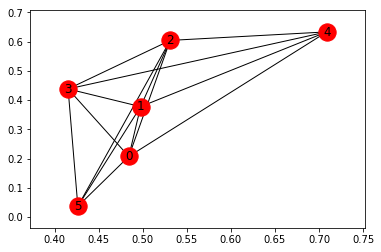

In [140]:
# Test the function
%time example = make_xy_clique_add_nodes_iter(3,4,3)
xy_coords = []
for x,y in zip(
               list(nx.get_node_attributes(example,'x').values()), 
               list(nx.get_node_attributes(example,'y').values())
               ): 
    xy_coords.append([x, y])
nx.draw_networkx(example, xy_coords)

Figure 1-1) Example graph to show that the function does what it is designed to do.

#### 2) Using your KNN model function, construct networks with N=10000, n0=4 and K=4. Does this model generate scale-free networks?  Does it generate small-world networks?  Justify your answer with the appropriate graphs.

In [17]:
%time prob2 = make_xy_clique_add_nodes_iter(4,4,10000)

CPU times: user 2min 43s, sys: 80 ms, total: 2min 43s
Wall time: 2min 43s


In [18]:
prob2_degree = prob2.degree()
prob2_degree_count = Counter(prob2_degree.values())

In [30]:
k = list(prob2_degree_count.keys())
N = list(prob2_degree_count.values())
Pk = [x / 10000. for x in prob2_degree_count.values()]

In [104]:
def func_powerlaw(k, C, gamma):
    return C * (k**(-gamma))

In [115]:
popt, pcov = curve_fit(func_powerlaw, k, Pk)#, bounds=([-100,0], [100,1]))
print("C = ", popt[0],
      "\nGamma = ", popt[1],"\n")
print("Variance of C = ", pcov[0][0],
      "\nCovariance of C and Gamma = ", pcov[0][1], 
      "\nVariance of Gamma = ", pcov[1][1])

C =  2.22801209064 
Gamma =  1.6785940112 

Variance of C =  0.0819819570996 
Covariance of C and Gamma =  0.0206911371742 
Variance of Gamma =  0.00550477255389


[0, 100, 1e-05, 0.225]

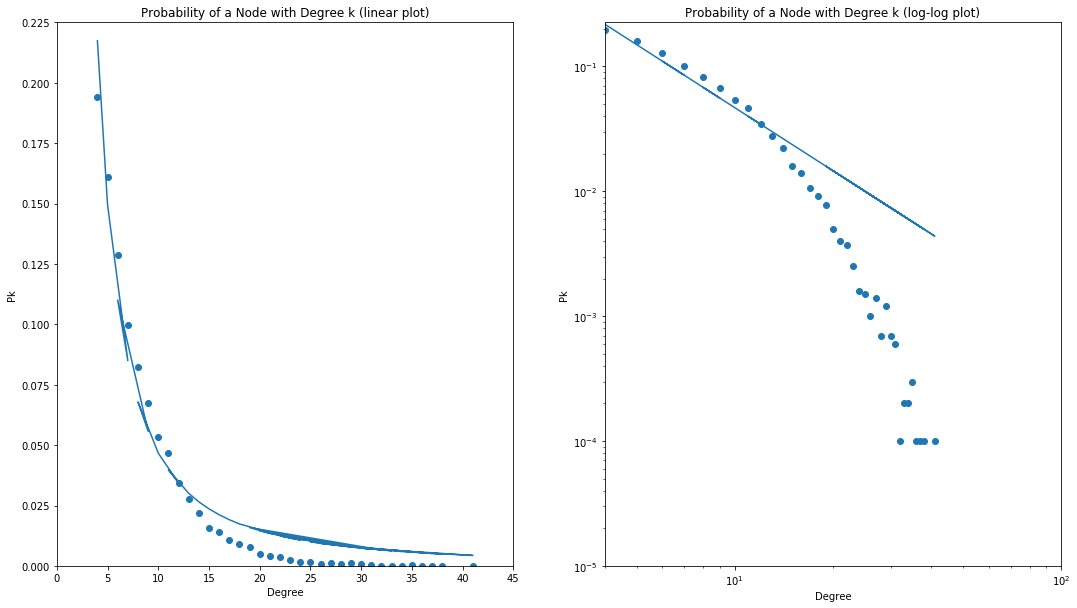

In [116]:
plt.figure(figsize=(18, 10))

plt.subplot(121)
plt.scatter(k, Pk)
plt.title('Probability of a Node with Degree k (linear plot)')
plt.xlabel('Degree')
plt.ylabel('Pk')
plt.plot(k, func_powerlaw(k, popt[0], popt[1]))
plt.axis([0, 45, 0, 0.225])

plt.subplot(122)
plt.scatter(k, Pk)
plt.title('Probability of a Node with Degree k (log-log plot)')
plt.xlabel('Degree')
plt.ylabel('Pk')
plt.xscale('log')
plt.yscale('log')
plt.plot(k, func_powerlaw(k, popt[0], popt[1]), label='fit')
plt.axis([0, 100, 1e-05, 2.25e-01])

Figure 2-1) The distribution of the degree k of the nodes generated from the G=KNN model where n0=1000, K=4, and N=4).

In Figure 2-1, the plot on the left is a linear plot of Degree (k) vs. Probability of Node Degree k, its shows an exponential decay. The plot in the top-right is a log-log plot of Degree (k) vs. Probability of Node Degree k, its nodes follow a decreasing linear trend; this looks a lot like a power law meaning this data <b>is a scale-free network</b>. A random network would have a Poisson distribution; a hump would be located in the middle of the degree distribution in the plot in the top-left.

Fitting my data to the power law $Pk = Ck^{-\gamma}$, results in gamma being equal to 1.68. This does not make sense, we expect $2<\gamma$ since large graphs often have small-world phenomena and to have this phenomena, $2<\gamma$. The curve I have fit here does not match the data very well...

#### 3) Tweak the previous KNN model such that for every new node, half of its edges are placed based on the nearest-neighbors rule, while the other half are placed based on the random “link-selection” model, described in class and in Section 5.9.2 of Barabasi’s book. How does the resulting degree distribution of this model relate to the degree distribution of the original model? (include relevant graphs)

In [303]:
def make_xy_clique_add_nodes_iter_half_random(n0, K, N):
    """
    Same as function above, except when a new node is added, half of its edges are added to its nearest neighbor,
    while the other half are added randomly.
    """
    
    # Make the clique of n0 nodes
    graph = nx.complete_graph(n0)
    num_nodes = nx.number_of_nodes(graph)
    for node_num in range(num_nodes):
        graph.node[node_num]['x'] = np.random.random_sample()
        graph.node[node_num]['y'] = np.random.random_sample()
        node_num +=1
        
    # Initialize a list of xy coordinates of the nodes, this will be updated as new nodes are added
    x_coord = list(nx.get_node_attributes(graph,'x').values())
    y_coord = list(nx.get_node_attributes(graph,'y').values())
    xy_coords = []
    for x,y in zip(x_coord, y_coord): 
        xy_coords.append([x, y])
    
    # Adds the new nodes 1 at a time, adds thie coords to xy_coords list, 
    # and connects them to their K-nearest neighbors
    # If K is larger than the number of nodes in graph, then new node is connected to all nodes
    new_node_num = n0 + N
    for node_num in range(n0, new_node_num):
        graph.add_node(node_num)
        graph.node[node_num]['x'] = np.random.random_sample()
        graph.node[node_num]['y'] = np.random.random_sample()
        xy_coords.append([graph.node[node_num]['x'], graph.node[node_num]['y']])
        
        if node_num < K: 
            num_nbrs = node_num    
        else: 
            num_nbrs = K
        nbrs = NearestNeighbors(n_neighbors=num_nbrs+1).fit(xy_coords)
        distances, indices = nbrs.kneighbors(xy_coords)
        
        random_int = random.randint(0, num_nbrs)

        for nbr in range(1, num_nbrs+1-random_int):
            nrst_nbr = indices[node_num][nbr]
            graph.add_edge(node_num, nrst_nbr)
            
        nodes_tried = []
        while random_int > 0:
            random_edge = random.choice(graph.edges())
            if graph.has_edge(node_num, random_edge[0]) and random_edge[0] not in nodes_tried:
                nodes_tried.append(random_edge[0])
            elif graph.has_edge(node_num, random_edge[0]) and random_edge[0] in nodes_tried:
                continue
            elif not graph.has_edge(node_num, random_edge[0]):
                graph.add_edge(node_num, random_edge[0])
                nodes_tried.append(random_edge[0])
                random_int-=1
            else:
                random_int-=1  
    
    return graph

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.66 ms


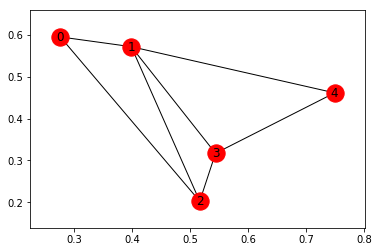

In [304]:
# Test the function
%time example2 = make_xy_clique_add_nodes_iter_half_random(3,2,2)
xy_coords = []
for x,y in zip(
               list(nx.get_node_attributes(example2,'x').values()), 
               list(nx.get_node_attributes(example2,'y').values())
               ): 
    xy_coords.append([x, y])
nx.draw_networkx(example2, xy_coords)

In [ ]:
%time prob3 = make_xy_clique_add_nodes_iter_half_random(4,4,10000)